In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, cohen_kappa_score, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from joblib import dump, Parallel, delayed

In [ ]:
tes = 'AAIndex-Morgan'

In [2]:
X = pd.read_csv('../../data/4-modelling/1-datainput/aaindex-morgan_chembl.csv')
y = X.pop('Class')
X

,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,BIGC670101,BIOV880101,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,3.066707,-2.170256,-1.977858,-2.333132,-2.488069,-2.677095,2.738514,2.638519,-0.334663,-2.453463,...,0,0,0,1,0,1,0,0,0,0
1,3.066707,-2.170256,-1.977858,-2.333132,-2.488069,-2.677095,2.738514,2.638519,-0.334663,-2.453463,...,0,0,0,0,0,1,1,0,0,0
2,1.383463,0.391879,-0.959167,-0.895293,-0.823573,0.666852,0.722144,-0.242320,0.448794,0.459470,...,0,0,0,0,0,0,0,0,0,0
3,1.383463,0.391879,-0.959167,-0.895293,-0.823573,0.666852,0.722144,-0.242320,0.448794,0.459470,...,0,0,0,1,0,0,0,0,0,0
4,1.383463,0.391879,-0.959167,-0.895293,-0.823573,0.666852,0.722144,-0.242320,0.448794,0.459470,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,-0.411820,0.698588,1.259762,1.148029,0.956758,0.614219,-0.637768,-0.880549,0.794245,0.890624,...,1,0,0,0,0,0,0,0,0,0
1354,-0.437278,-0.165105,-0.783151,-0.720472,0.166092,-1.055810,0.203921,1.306768,0.001005,-1.074539,...,0,0,0,0,0,0,0,0,0,0
1355,-0.437278,-0.165105,-0.783151,-0.720472,0.166092,-1.055810,0.203921,1.306768,0.001005,-1.074539,...,0,0,0,0,0,1,0,0,0,0
1356,-0.437278,-0.165105,-0.783151,-0.720472,0.166092,-1.055810,0.203921,1.306768,0.001005,-1.074539,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1353    0
1354    0
1355    0
1356    0
1357    0
Name: Class, Length: 1358, dtype: int64

In [4]:
if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
    X = X.values
if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
    y = y.values

In [5]:
# Models and hyperparameter grids
param_grids = {
    "MLP": {
        "hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "activation": ["tanh", "relu"],
        "solver": ["adam", "sgd"],
        "alpha": [0.0001, 0.001, 0.01],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.7, 0.8, 1.0],
    },
    "Logistic Regression": {
        "C": [0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs", "liblinear"],
    },
}

In [6]:
models = {
    #"MLP": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    #"XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
}

In [7]:
# Cross-validation and metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metrics = [
    ("Accuracy", accuracy_score),
    ("Recall", recall_score),
    ("Precision", precision_score),
    ("F1-Score", f1_score),
    ("AUC", roc_auc_score),
    ("Cohen Kappa", cohen_kappa_score),
]

In [10]:
results = []
roc_curves = []

for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids[model_name]

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=2,
        scoring="accuracy",
        cv=cv,
        random_state=42,
        verbose=1,
        n_jobs=-1,  # Parallelize RandomizedSearchCV
    )
    random_search.fit(X, y)
    best_model = random_search.best_estimator_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")

    # Save Random Search results
    random_search_df = pd.DataFrame(random_search.cv_results_)
    random_search_df.to_csv(f"../../data/4-modelling/result/chembl/{tes}/random_search_{model_name.replace(' ', '_').lower()}.csv", index=False)

    # Save the best model
    model_path = f"../../data/4-modelling/result/chembl/{tes}/best_model_{model_name.replace(' ', '_').lower()}.joblib"
    dump(best_model, model_path)
    print(f"Best model for {model_name} saved to {model_path}")

    print(f"Evaluating {model_name}...")
    metric_scores = {metric[0]: [] for metric in metrics}
    all_roc_data = []

    # Parallel evaluation for each fold
    def evaluate_fold(train_idx, test_idx):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_proba = (
            best_model.predict_proba(X_test)[:, 1]
            if hasattr(best_model, "predict_proba")
            else None
        )

        fold_results = {}
        for metric_name, metric_func in metrics:
            if metric_name == "AUC" and y_proba is not None:
                score = metric_func(y_test, y_proba)
            elif metric_name != "AUC":
                score = metric_func(y_test, y_pred)
            else:
                score = np.nan
            fold_results[metric_name] = score

        # Compute ROC curve
        roc_data = {}
        if y_proba is not None:
            fpr, tpr, thresholds = roc_curve(y_test, y_proba)
            roc_data = {"FPR": fpr, "TPR": tpr, "Thresholds": thresholds}

        return fold_results, roc_data

    results_per_fold = Parallel(n_jobs=-1)(
        delayed(evaluate_fold)(train_idx, test_idx) for train_idx, test_idx in cv.split(X, y)
    )

    for fold_results, roc_data in results_per_fold:
        for metric_name, score in fold_results.items():
            metric_scores[metric_name].append(score)
        if roc_data:
            all_roc_data.append(roc_data)

    # Store mean and std metrics
    result = {
        "Model": model_name,
        **{f"Mean {metric[0]}": np.mean(scores) for metric, scores in zip(metrics, metric_scores.values())},
        **{f"Std {metric[0]}": np.std(scores) for metric, scores in zip(metrics, metric_scores.values())},
    }
    results.append(result)

    # Save ROC curve data
    roc_data_combined = {
        "FPR": [],
        "TPR": [],
        "Thresholds": [],
        "Fold": [],
    }
    for fold_idx, roc_data in enumerate(all_roc_data, start=1):
        roc_data_combined["FPR"].extend(roc_data["FPR"])
        roc_data_combined["TPR"].extend(roc_data["TPR"])
        roc_data_combined["Thresholds"].extend(roc_data["Thresholds"])
        roc_data_combined["Fold"].extend([fold_idx] * len(roc_data["FPR"]))

    roc_df = pd.DataFrame(roc_data_combined)
    roc_df.to_csv(f"../../data/4-modelling/result/chembl/{tes}/roc_curve_{model_name.replace(' ', '_').lower()}.csv", index=False)

# Save summary results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f"../../data/4-modelling/result/chembl/{tes}/evaluation_metrics.csv", index=False)

print("Evaluation completed. All results saved in the 'result' folder.")

Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': None}
Best model for Random Forest saved to ../../data/4-modelling/result/chembl/AAIndex-Morgan/best_model_random_forest.joblib
Evaluating Random Forest...
Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
Best model for Logistic Regression saved to ../../data/4-modelling/result/chembl/AAIndex-Morgan/best_model_logistic_regression.joblib
Evaluating Logistic Regression...
Evaluation completed. All results saved in the 'result' folder.


In [11]:
results_df

,Model,Mean Accuracy,Mean Recall,Mean Precision,Mean F1-Score,Mean AUC,Mean Cohen Kappa,Std Accuracy,Std Recall,Std Precision,Std F1-Score,Std AUC,Std Cohen Kappa
0,Random Forest,0.807027,0.855675,0.782681,0.816573,0.907706,0.614003,0.033270,0.027324,0.045006,0.026214,0.018992,0.066693
1,Logistic Regression,0.770219,0.779031,0.770361,0.772536,0.863685,0.540344,0.027592,0.040627,0.048447,0.020332,0.031755,0.055300


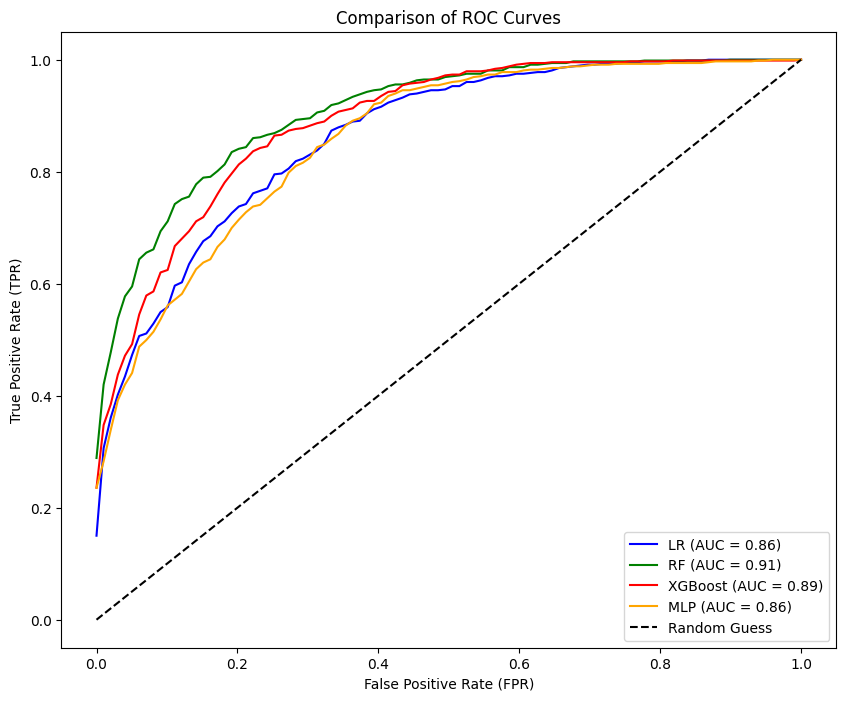

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Fungsi untuk menghitung rata-rata ROC dan AUC
def compute_mean_roc(roc_df, label):
    # Interpolasi TPR berdasarkan FPR yang sama
    fpr_values = np.linspace(0, 1, 100)
    tpr_interpolated = []
    
    for fold in roc_df['Fold'].unique():
        fold_data = roc_df[roc_df['Fold'] == fold]
        tpr_interp = np.interp(fpr_values, fold_data['FPR'], fold_data['TPR'])
        tpr_interpolated.append(tpr_interp)
    
    # Hitung rata-rata dan standar deviasi TPR
    tpr_mean = np.mean(tpr_interpolated, axis=0)
    tpr_std = np.std(tpr_interpolated, axis=0)
    
    # Hitung AUC rata-rata
    mean_auc = auc(fpr_values, tpr_mean)
    
    return fpr_values, tpr_mean, tpr_std, mean_auc

# Load file ROC dari model 1 dan 2
roc_df_model1 = pd.read_csv("../../data/4-modelling/result/chembl/aaindex-morgan/roc_curve_logistic_regression.csv")
roc_df_model2 = pd.read_csv("../../data/4-modelling/result/chembl/aaindex-morgan/roc_curve_random_forest.csv")
roc_df_model3 = pd.read_csv("../../data/4-modelling/result/chembl/aaindex-morgan/roc_curve_xgboost.csv")
roc_df_model4 = pd.read_csv("../../data/4-modelling/result/chembl/aaindex-morgan/roc_curve_mlp.csv")

# Hitung ROC rata-rata untuk kedua model
fpr1, tpr1_mean, tpr1_std, auc1 = compute_mean_roc(roc_df_model1, "LR")
fpr2, tpr2_mean, tpr2_std, auc2 = compute_mean_roc(roc_df_model2, "RF")
fpr3, tpr3_mean, tpr3_std, auc3 = compute_mean_roc(roc_df_model3, "XGBoost")
fpr4, tpr4_mean, tpr4_std, auc4 = compute_mean_roc(roc_df_model4, "MLP")

# Plot ROC Curve untuk kedua model
plt.figure(figsize=(10, 8))

# Model 1
plt.plot(fpr1, tpr1_mean, label=f"LR (AUC = {auc1:.2f})", color="blue")
plt.plot(fpr2, tpr2_mean, label=f"RF (AUC = {auc2:.2f})", color="green")
plt.plot(fpr3, tpr3_mean, label=f"XGBoost (AUC = {auc3:.2f})", color="red")
plt.plot(fpr4, tpr4_mean, label=f"MLP (AUC = {auc4:.2f})", color="orange")

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# Tambahkan label dan judul
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Comparison of ROC Curves")
plt.legend(loc="lower right")

# Simpan plot ke file
#plt.savefig("result/comparison_roc_curve_plot.png")
plt.show()